# Consurso interno de predicción de Oracle
Alejandro Ozymandias Cepeda Beltran

In [290]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Obtención de datos del stock de Oracle

In [291]:
datos_orcl = pd.read_csv('oracle_stock_prices.csv')
print(datos_orcl.shape)
datos_orcl.head()

(726, 6)


,Date,Open,High,Low,Close,Volume
0,3/01/2023 16:00:00,"82,47","83,84","82,26","83,72",8997534
1,4/01/2023 16:00:00,"84,2","85,17","83,64","84,48",7836238
2,5/01/2023 16:00:00,85,"85,4","83,22","84,31",7643784
3,6/01/2023 16:00:00,"84,74","86,34","83,82","85,66",8641597
4,9/01/2023 16:00:00,"86,84","87,59","86,16","86,42",7519836


In [292]:

close_data = datos_orcl['Close'].values
for i in range(len(close_data)):
    a = close_data[i].replace(',','.')
    close_data[i] = float(a)
close_data = list(close_data.astype('float32'))

#cambio contra solución 1
data = close_data

print(data)

[np.float32(83.72), np.float32(84.48), np.float32(84.31), np.float32(85.66), np.float32(86.42), np.float32(86.5), np.float32(88.6), np.float32(88.78), np.float32(89.2), np.float32(88.6), np.float32(86.71), np.float32(85.94), np.float32(87.25), np.float32(88.97), np.float32(89.7), np.float32(89.64), np.float32(89.83), np.float32(88.99), np.float32(87.35), np.float32(88.46), np.float32(90.05), np.float32(89.38), np.float32(89.62), np.float32(88.53), np.float32(87.74), np.float32(86.69), np.float32(86.65), np.float32(87.14), np.float32(89.42), np.float32(89.09), np.float32(88.34), np.float32(87.72), np.float32(87.28), np.float32(86.2), np.float32(86.32), np.float32(88.58), np.float32(88.66), np.float32(87.96), np.float32(87.4), np.float32(86.34), np.float32(86.97), np.float32(89.25), np.float32(89.74), np.float32(88.36), np.float32(88.49), np.float32(86.87), np.float32(84.07), np.float32(84.93), np.float32(84.56), np.float32(82.98), np.float32(84.82), np.float32(85.26), np.float32(86.96),

### 1. CONFIGURACIÓN Y GENERACIÓN DE DATOS

In [293]:
def crear_secuencias(datos, ventana):
    
    secuencias = []
    labels = []
    fac_divi = []
    L = len(datos)
    for i in range(L - ventana):
        # Tomamos 'ventana' pasos como input
        seq = datos[i : i + ventana]
        # El siguiente paso es lo que queremos predecir
        label = datos[i + ventana]
        #obtenemos el máximo de la secuencia para normalizar
        maximo = max(seq)
        seq = [p / maximo for p in seq]
        label = label / maximo

        secuencias.append(seq)
        labels.append(label)
        fac_divi.append(maximo)  # Factor de división para desnormalizar
    return np.array(secuencias), np.array(labels), np.array(fac_divi)

# Hiperparámetros
ventana_tiempo = 50  # Cuántos pasos hacia atrás mira la red
test_size = 100

# Preparar dataset
X, y, fac_divi = crear_secuencias(data, ventana_tiempo)

X.shape


(676, 50)

### 2. PREPARACIÓN DE TENSORES

In [294]:
# Dividir en train/test
train_X = torch.Tensor(X[:-test_size])
train_y = torch.Tensor(y[:-test_size])
test_X = torch.Tensor(X[-test_size:])
test_y = torch.Tensor(y[-test_size:])
train_div = torch.Tensor(fac_divi[:-test_size])
test_div = torch.Tensor(fac_divi[-test_size:])

# Añadir la dimensión de "Features" (Input_Size) al final
# De (Batch, 50) pasamos a (Batch, 50, 1)
train_X = train_X.unsqueeze(-1)
test_X = test_X.unsqueeze(-1)
# Las etiquetas también necesitan forma correcta para el Loss
train_y = train_y.unsqueeze(-1)
test_y = test_y.unsqueeze(-1)

print(f"Forma de entrada a la LSTM: {train_X.shape}")

Forma de entrada a la LSTM: torch.Size([576, 50, 1])


### 3. Definición del modelo

In [295]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, output_dim=1, num_layers=1):
        super(LSTMPredictor, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Definición de la capa LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,     # 1 (solo el valor del seno)
            hidden_size=hidden_dim,   # 50 neuronas en la memoria
            num_layers=num_layers,    # 1 capa apilada
            batch_first=True          # Importante para usar (Batch, Seq, Feat)
        )
        
        # Capa lineal para decodificar la salida de la LSTM a un solo valor
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Features)
        
        # LSTM devuelve: output, (hidden_state, cell_state)
        # output contiene los estados ocultos de TODA la secuencia
        lstm_out, _ = self.lstm(x)
        
        # Solo nos interesa la predicción del ÚLTIMO paso de tiempo
        # Tomamos el último slice temporal: [:, -1, :]
        last_time_step = lstm_out[:, -1, :]
        
        # Pasamos por la lineal para obtener la predicción final
        prediccion = self.linear(last_time_step)
        
        return prediccion
    
# Instanciar modelo, pérdida y optimizador
modelo = LSTMPredictor()
loss_function = nn.MSELoss() # Error Cuadrático Medio (estándar para regresión)
# Optimizador Adam con learning rate de 0.001
optimizer = optim.Adam(modelo.parameters(), lr=0.005)


### 4. Entrenamiento

In [296]:
epochs = 30
grafica = []
print("\nIniciando entrenamiento...")

for i in range(epochs):
    modelo.train()
    
    # 1. Resetear gradientes
    optimizer.zero_grad() 
    
    # 2. Forward pass (Predecir)
    y_pred = modelo(train_X)
    
    # 3. Calcular pérdida
    loss = loss_function(y_pred, train_y)
    
    # 4. Backward pass (Calcular gradientes)
    loss.backward()
    
    # 5. Actualizar pesos
    optimizer.step() 
    
    #if i%5  == 0:
    grafica.append(loss.item())
    print(f'Epoch {i} Loss: {loss.item():.6f}')

print("Entrenamiento finalizado.\n")


Iniciando entrenamiento...
Epoch 0 Loss: 0.868479
Epoch 1 Loss: 0.724297
Epoch 2 Loss: 0.571292
Epoch 3 Loss: 0.399163
Epoch 4 Loss: 0.203794
Epoch 5 Loss: 0.021621
Epoch 6 Loss: 0.203229
Epoch 7 Loss: 0.121583
Epoch 8 Loss: 0.018890
Epoch 9 Loss: 0.005746
Epoch 10 Loss: 0.027836
Epoch 11 Loss: 0.048411
Epoch 12 Loss: 0.057953
Epoch 13 Loss: 0.056632
Epoch 14 Loss: 0.047386
Epoch 15 Loss: 0.033924
Epoch 16 Loss: 0.020085
Epoch 17 Loss: 0.009305
Epoch 18 Loss: 0.003901
Epoch 19 Loss: 0.004325
Epoch 20 Loss: 0.008910
Epoch 21 Loss: 0.014570
Epoch 22 Loss: 0.018305
Epoch 23 Loss: 0.018589
Epoch 24 Loss: 0.015776
Epoch 25 Loss: 0.011437
Epoch 26 Loss: 0.007314
Epoch 27 Loss: 0.004570
Epoch 28 Loss: 0.003559
Epoch 29 Loss: 0.003996
Entrenamiento finalizado.



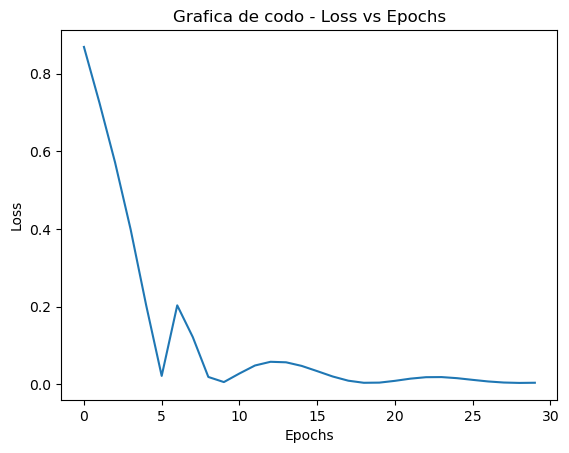

In [297]:
################# Gráfica de codo ####################

# Import required libraries
import matplotlib.pyplot as plt

# Create a simple line plot
plt.plot(grafica)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Grafica de codo - Loss vs Epochs')

# Display the plot
plt.show()

### 5. Evaluación

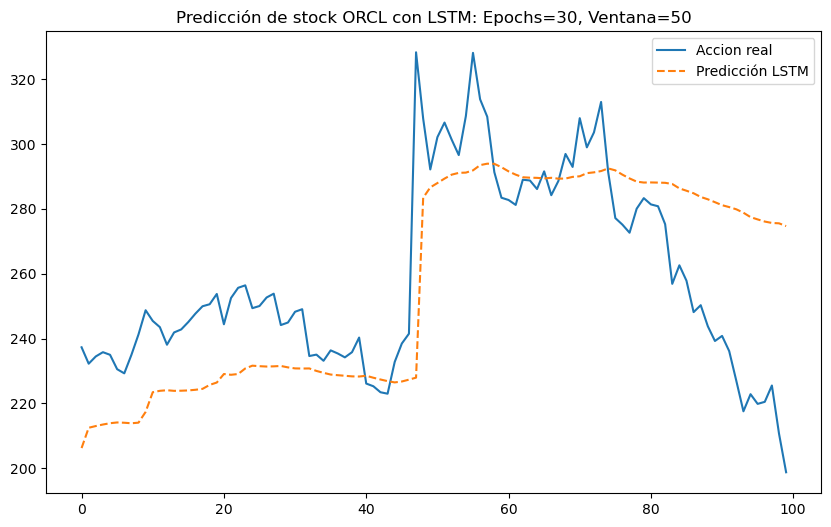

Ejemplo de predicción vs real:
Real: 237.3200 | Predicho: 206.2318


In [300]:
modelo.eval()
with torch.no_grad():
    test_pred = modelo(test_X)

# Convertir a numpy para graficar
real = test_y.numpy()
real = [r*d for r, d in zip(real, test_div.numpy())]
predicho = test_pred.numpy()
predicho = [p*d for p, d in zip(predicho, test_div.numpy())]

# Descomenta las siguientes líneas si estás en un entorno con pantalla gráfica (Jupyter/Local)
plt.figure(figsize=(10,6))
plt.plot(real, label='Accion real')
plt.plot(predicho, label='Predicción LSTM', linestyle='dashed')
plt.legend()
plt.title(f'Predicción de stock ORCL con LSTM: Epochs={epochs}, Ventana={ventana_tiempo}')
plt.show()

print("Ejemplo de predicción vs real:")
print(f"Real: {real[0][0]:.4f} | Predicho: {predicho[0][0]:.4f}")